In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt
import pickle

In [2]:
#if you want to record the calculation time: 

import timeit

start = timeit.default_timer()

#Your statements here
test=1+2

stop = timeit.default_timer()

print('Time: ', stop - start) 

Time:  0.0001110070000009955


 Consider the one dimensional N-spin Ising model, in which each site is associated with a variable $s_i=1,-1$. The energy is 

\begin{align}
E=-\frac{J}{2} \sum_{i=0,,, N-1} s_{i}\left(s_{i+1}+s_{i-1}\right)-B \sum_{i} s_{i}
\end{align}

It has periodic boundary conditions: $s_i=s_{N+i}$

Based on Monte Caro method, the main procedure is as follows:
1. Create a N * 1 lattice, and start with a given spin configuration $s_p$ and energy $E_p$

2. Select a site at random and propose to flip the spin on that site (i.e. change the sign of the variable on that site).

3. Compute the new energy $E_{new}$, and calculate the energy difference $\Delta E = E_{new} - E_p$ .

4. Accept or reject the proposal with the detailed balance probability:
a) if $\Delta E<=0$, accept the proposal. b) if $\Delta E>0$, accept the proposal with probability $P = e^{−\frac{\Delta E }{T}}$, and reject proposal with probability 1-P.

5. Return either the original state or the new state according to whether the proposal is accepted.

6. Go back to step 2, repeat the procedure n_max times until it reaches equilibrium. 
* we need to consider boundary conditions: we can use i% N: 0%N=0, (N+2)%N=2


In [3]:
"""
Compute the energy for a given spin configuration.
s: a 1D list of the spin configuration. For example, s=[1,-1,1...]
N: the size of the lattice
J: J = 1 prefers a ferromagnetic configuration. J = -1 prefers a anti-ferromagnetic configuration. 
   By default, we choose J=1
B: magnetic field
"""

def energy(s,N,J=1,B=1):
    E = 0
    for i in range(len(s)):
        if i == 0: 
            E += -J/2*s[i]* (s[i+1]+s[N-1]) - B*s[i]
        elif i == N-1:
            E += -J/2*s[i]* (s[0]+s[i-1]) - B*s[i]
        else:
            E += -J/2*s[i]* (s[i+1]+s[i-1]) - B*s[i]
    return(E)

# or you can write this:

def energy(s,N,J=1,B=1):
    E = 0
    for i in range(len(s)):
        E += -J/2*s[i]*(s[(i+1) % N] + s[(i-1) % N]) - B*s[i]
    return(E)


In [4]:
"""
Step 1. Create an initial 1D N-spin lattice with all spins up. 

"""
def initial_lattice(N=10):
    return np.ones(N)

# in 2D, it can be generalized to np.ones((N,N))

In [5]:
"""
Step 2. Select a site at random and propose to flip the spin on that site.

s: the list of the old spin configuration.
s_prop: the list of the proposed spin configuration.
i: a random site chosen to be flipped

"""

def propose(s):
    i=np.random.randint(len(s))
    s_prop = s.copy()
    s_prop[i] = -s[i]
    return s_prop, i

In [6]:
"""
Step 3&4&5. Calculate the energy difference. Accept or reject the proposal with the detailed balance probability. 
            Return either the original state or the new state according to whether the proposal is accepted.

"""

def update(s_prop,s,i,N,J=1,B=1,T=1):
    

    e_i= -J*s[i]*(s[(i+1)%N] + s[(i-1)%N]) - B*s[i] # the energy related to the spin i in the old system
    
    dE =  -2*e_i # dE= E_new-E_old = (-e_i)-e_i=-2e_i
    
    if dE <=0:
        return s_prop
    
    else:
        random_num = random.random()
        if random_num < np.exp(-dE/T):
            return s_prop
        else:
            return s
        

In [13]:
"""
Based on the two functions "propose" and "update", construct a function that generates 
a list of length n_max ofstates that are visited, and record their energy and magnetization.

s_start: the list of the initial spin configuration.
namx: the number of iterations
m: We perform a measurement only after m proposed updates, so we can get a more stable measurement.
"""

def generate(s_start,nmax,J=1,B=1,T=1,m=5):
    N = len(s_start)
    list_mag=[np.sum(s_start),]
    s = s_start
    for n in range(nmax): 
        s_prop, i = propose(s)
        s_new = update(s_prop,s,i,N,J,B,T)
        if n%m==0:
            list_mag.append(np.sum((s_new)))
        s = s_new
    list_mag=np.array(list_mag)
    return(list_mag,s)

After setting up all the function, at any given magnetic field and temperature, we can get a sequence of the spin system in the evolution:

In [8]:
J=1
B=0
N=50
T=100
s_start=initial_lattice(N)
nmax = 20000
m=5
list_mag = generate(s_start,nmax,J,B,T,m)

Let's t track the magnetization in the evolution. 

Below shows the magnetization at T= {1, 1.5, 5} with B=0. We can find that when temperature is lower, it takes longer time to reach equilibrium. 

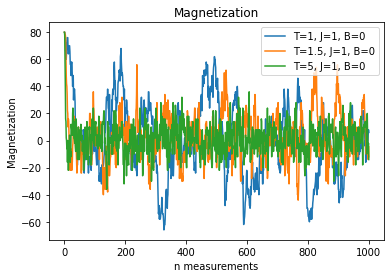

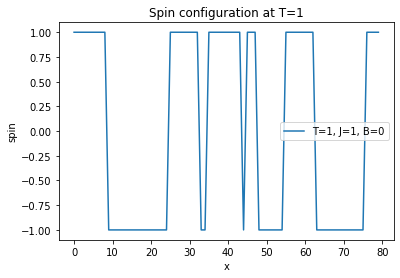

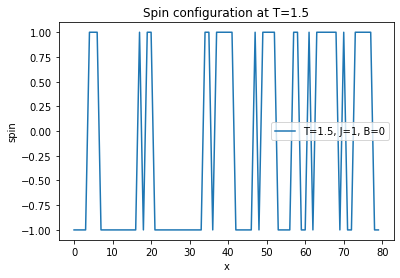

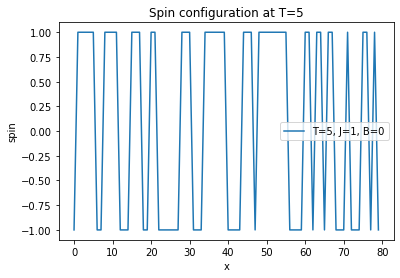

In [28]:
J=1
B=0
N=80
s_start=initial_lattice(N)
nmax = 50000 
m=50 # measure the value every 50 updates
n_measure=int((nmax)/m) # the number of measurements = nmax/m
Tlist=[1,1.5,5]  #the temperature list
slist=[] #the final spin configurations at different temperatures
for T in Tlist:
    list_mag,s= generate(s_start,nmax,J,B,T,m)
    slist.append(s)
    plt.plot(list_mag, label = f"T={T}, J={J}, B={B}")
plt.ylabel(r'Magnetization')
plt.xlabel(r'n measurements')
plt.title('Magnetization')
plt.legend()
plt.show()

for i, T in enumerate(Tlist):
    
    plt.plot(slist[i],label = f"T={T}, J={J}, B={B}")
    plt.ylabel(r'spin')
    plt.xlabel(r'x')
    plt.title(f'Spin configuration at T={T}')
    plt.legend()
    plt.show()
    

To get a more reliable result, we can also repeat this random walk 100 times, and the final result will be the average of 100 independent evolutions.

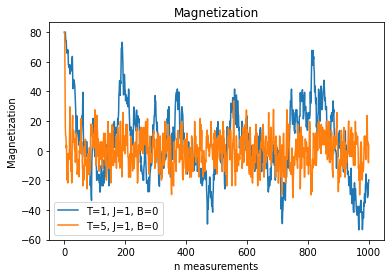

In [20]:
J=1
B=0
N=80
s_start=initial_lattice(N)
nmax = 50000
m=50 # measure the value every 50 updates
n_measure=int((nmax)/m) # the number of measurements = nmax/m
Tlist=[1,5]  #the temperature list

for T in Tlist:
    list_mag_old,_ = generate(s_start,nmax,J,B,T,m)
    for r in range(1,100):
        #do the random walk 100 times independiently, it may take a long time! 
        list_mag,_ = generate(s_start,nmax,J,B,T,m)
        mag_100=list_mag_old*(r-1)/r+list_mag/r
        list_mag_old=list_mag
    np.save(f'T={T}_B={B}.npy', mag_100)  # save the value, in order to use the list later repeatedly in the follwing caclulation    
    plt.plot(mag_100, label = f"T={T}, J={J}, B={B}")
plt.ylabel(r'Magnetization')
plt.xlabel(r'n measurements')
plt.title('Magnetization')
plt.legend()
plt.show()
    


For a physical quantity A, we can also track the running average value $A_{ave}$ after n measurements in a sequence. And we can produce a list whose nth entry is the average value after n steps in the random walk:

$A_{ave}(n)=\frac{1}{n} \sum_{i=1}^{n} A_{i}=\frac{n-1}{n} A_{ave}(n-1)+\frac{1}{n} A_{n}$,
where $A_{ave}(n-1)=\frac{1}{n-1} \sum_{i=1}^{n-1} A_{i}$

In [21]:
def average(n,old_ave,value_n):
    """
    n: the nth entry
    old_ave: the n-1th entry of the list of average value
    value_n: the nth value
    """
    return (n-1)*old_ave/n + value_n/n


Therefore, to see the above evolution more clearly, let's calculate the running average of magnetization:

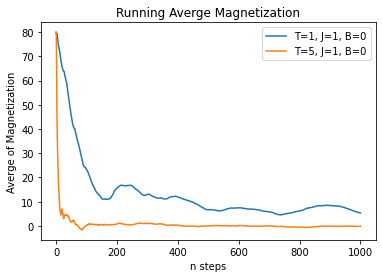

In [22]:
J=1
B=0
N=50
nmax = 20000
s_start=initial_lattice(N)

for T in Tlist:
    list_mag=np.load(f'T={T}_B={B}.npy')

    list_aveM = [list_mag[0],]
    
    old_ave = list_mag[0]
    for n in range(1,len(list_mag)):
        new_ave= average(n,old_ave, list_mag[n])
        list_aveM.append(new_ave)
        old_ave = new_ave
    
    plt.plot(list_aveM, label = f"T={T}, J={J}, B={B}")

plt.ylabel(r'Averge of Magnetization')
plt.xlabel(r'n steps')
plt.title('Running Averge Magnetization')
plt.legend()
plt.show()
    

We can also calculate the susceptibility:

$\chi=\frac{1}{T}<M^2>-\frac{1}{T}<M>^{2}$

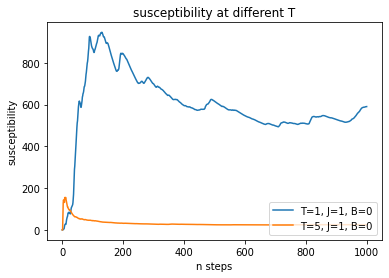

In [23]:
J=1
B=0
N=50
nmax = 20000
s_start=initial_lattice(N)

for T in Tlist:
    list_mag=np.load(f'T={T}_B={B}.npy')

    #calculate the average of M:
    old_ave = list_mag[0]
    list_aveM = [old_ave,]
    
    for n in range(1,len(list_mag)):
        new_ave= average(n,old_ave, list_mag[n])
        list_aveM.append(new_ave)
        old_ave = new_ave
    list_aveM=np.array(list_aveM)
    
    #calculate the average of M^2:
    old_ave = list_mag[0]**2        
    list_aveM2 = [old_ave,]

    for n in range(1,len(list_mag)):
        new_ave= average(n,old_ave, list_mag[n]**2)
        list_aveM2.append(new_ave)
        old_ave = new_ave
    list_aveM2=np.array(list_aveM2)
    
    sus=(list_aveM2-list_aveM**2)/T
    
    plt.plot(sus, label = f"T={T}, J={J}, B={B}")

plt.ylabel(r'susceptibility')
plt.xlabel(r'n steps')
plt.title('susceptibility at different T')
plt.legend(loc='lower right')
plt.show()

